<a href="https://colab.research.google.com/github/saimani5/Adatom_interactions/blob/main/Zheng_reconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install nanonispy                            #Translator for sxm file
import numpy as np
import nanonispy as nap
import matplotlib.pyplot as plt
from skimage.feature import blob_dog, blob_log, blob_doh  #atom finding
from scipy import fftpack, ndimage
import cv2
from matplotlib import patches
from scipy.ndimage import gaussian_filter
from scipy.signal import hamming
from matplotlib import patches
from sklearn.cluster import KMeans
import pandas as pd

Downloading...
From: https://drive.google.com/uc?id=1tU0EXr2-d-mnqKKyDktQjqb1QC_G4WWn
To: /content/Co3Sn2S2039.sxm
8.39MB [00:00, 126MB/s]


# Helper Functions


## Plane subtraction

Description to be written

In [2]:
def sub_plane(img):
    X1, X2 = np.mgrid[:img.shape[0], :img.shape[1]]
    X1, X2 = X1.reshape(-1,1), X2.reshape(-1,1)
    Y = img.reshape(img.shape[0]*img.shape[1], 1)
    Y = (Y - np.amin(Y))/np.ptp(Y)
    X = np.concatenate(
        (np.ones((X1.shape[0], 1)), X1, X2), axis = 1)
    theta = np.dot(np.dot(np.linalg.pinv(np.dot(X.T, X)), X.T), Y)
    plane = np.dot(X, theta).reshape(img.shape[0], img.shape[1]);
    Y_sub = Y.reshape(img.shape[0],img.shape[1]) - plane
    return Y_sub

## Remove atoms that are close to border

Deletes the atoms that are closer to the border than the set threshold. 
max_pix: Maximum number of pixels in the image 


In [3]:
def remove_border_atoms(com1,thresh = 5,max_pix = 512):
    ind = np.ones(len(com1), dtype=bool)
    for i, c in enumerate((com1)):
        if (c[0]-0)<thresh or (max_pix-c[0])<thresh or (c[1]-0)<thresh or (max_pix-c[1])<thresh:
            ind[i] = False
    
    return com1[ind]

## Estimating the nearest neighbors
**Input:** two sets of atomic coordinates  
computes the distances of user set number of (num) nearest neighbors and sorts them using angle  
Ignores the zero distance if same point is repeated in both the sets  

**Output:**
first two columns are y and x coordinates of nn respectively  
Third column is the distance and  
Fourth column is the angle to the nn



In [4]:
def estimate_nn(com1,com2,num = 6):
    """Input: two sets of atomic coordinates"""
    """computes the distances of 4 nearest neighbors and sorts them using angle"""
    """Ignores the zero distance if same point is repeated in both the sets"""
    mat = np.zeros([len(com1),num,4])
    ind = np.zeros([len(com1),num])
    ang = np.zeros([len(com1),num])
    dist_tot = np.zeros(len(com2))
    dist = np.zeros(num)
    ang = np.zeros(num)
    
    for i, c in enumerate(com1):
        dist_total = np.abs((com2[:,1]-c[1])+(1j*(com2[:,0]-c[0])))
        ang_total = np.angle((com2[:,1]-c[1])+(1j*(com2[:,0]-c[0])))
        sort_ind_dis = np.argsort(dist_total,axis=None)
        
        if np.amin(dist_total) == 0.0:
            dist = dist_total[sort_ind_dis[1:num+1]]
            nn = com2[sort_ind_dis[1:num+1]]
            ang = ang_total[sort_ind_dis[1:num+1]]
        else:
            dist = dist_total[sort_ind_dis[0:num]]
            nn = com2[sort_ind_dis[0:num]]
            ang = ang_total[sort_ind_dis[0:num]]
        
        mat[i,:,0:2] = nn
        mat[i,:,2] = dist
        mat[i,:,3] = ang
        
        """first two columns are y and x coordinates of nn respectively
           Third column is the distance and
           Fourth column is the angle to the nn"""
    return mat

In [5]:
"""Add atoms
Given a set of incomplete points and a unit cell (clus cen)
Places atoms at cluster centers for every point"""
def add_points(old_data, clus_cen):
    added_points_list = []
    for i,c in enumerate(old_data):
        for j,s in enumerate(clus_cen):
            dummy = c[0:2]+s
            if (dummy>0).all() and (dummy<512).all():
              added_points_list.append(c[0:2]+s)
    b = np.array(added_points_list)
    c = np.ones([len(b),1])
    d = np.concatenate((b,c), axis = 1)
#     print(np.shape(b))
#     print(np.shape(old_data))
    a = np.concatenate((old_data,d), axis = 0)
    return(a)

In [6]:
"""Clean atoms
For each atom, checks whether there are atoms within certain distance
If yes, the replaces the set of points with COM"""
def cleaning_up(old_data,avg_dist, thresh = 0.70):
    new_data_list = []
    i = 0
    while(len(old_data)>0):
        new_point = [0.0,0.0,0.0]
        # ind = np.random.randint(0,len(old_data))
        ind = 0
        c = old_data[ind]
        
        dist_total = np.abs((old_data[:,1]-c[1])+(1j*(old_data[:,0]-c[0])))
        dummy_data = old_data[dist_total<thresh*avg_dist]
        for j in range(len(dummy_data)):
            new_point[0] += (dummy_data[j,0]*dummy_data[j,2])
            new_point[1] += (dummy_data[j,1]*dummy_data[j,2])
        new_point[0] = new_point[0]/np.sum(dummy_data[:,2])
        new_point[1] = new_point[1]/np.sum(dummy_data[:,2])
        new_point[2] = np.sum(dummy_data[:,2])
        
        
        
        old_data = old_data[dist_total>=thresh*avg_dist]
        new_data_list.append(new_point)
        i += 1
    # print(i)
    return(np.array(new_data_list))

# Visualizing the image

In [7]:
imgfile = nap.read.Scan('Co3Sn2S2039.sxm')
for k, v in imgfile.signals.items():
    if isinstance(v, dict):
        print(k, '\n', v.keys())
    else:
        print(k.keys())

Z 
 dict_keys(['forward', 'backward'])
Current 
 dict_keys(['forward', 'backward'])
LIX_1_omega 
 dict_keys(['forward', 'backward'])
LIY_1_omega 
 dict_keys(['forward', 'backward'])


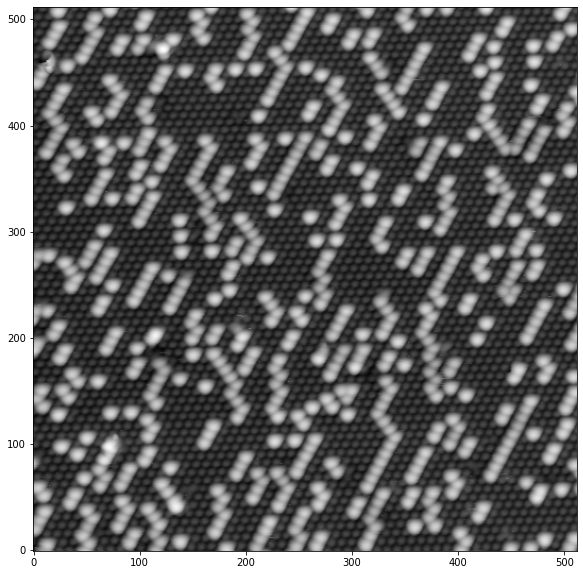

In [8]:
topo = imgfile.signals['Z']['forward']
topo_s = sub_plane(topo)
fig,ax = plt.subplots(figsize = (10,10))
ax.imshow(topo_s,cmap = 'gray')
ax.invert_yaxis()
# ax.set_xticks([])
# ax.set_yticks([])
plt.savefig('raw_image.png')

# Finding atoms

(1828, 3)
(681, 3)


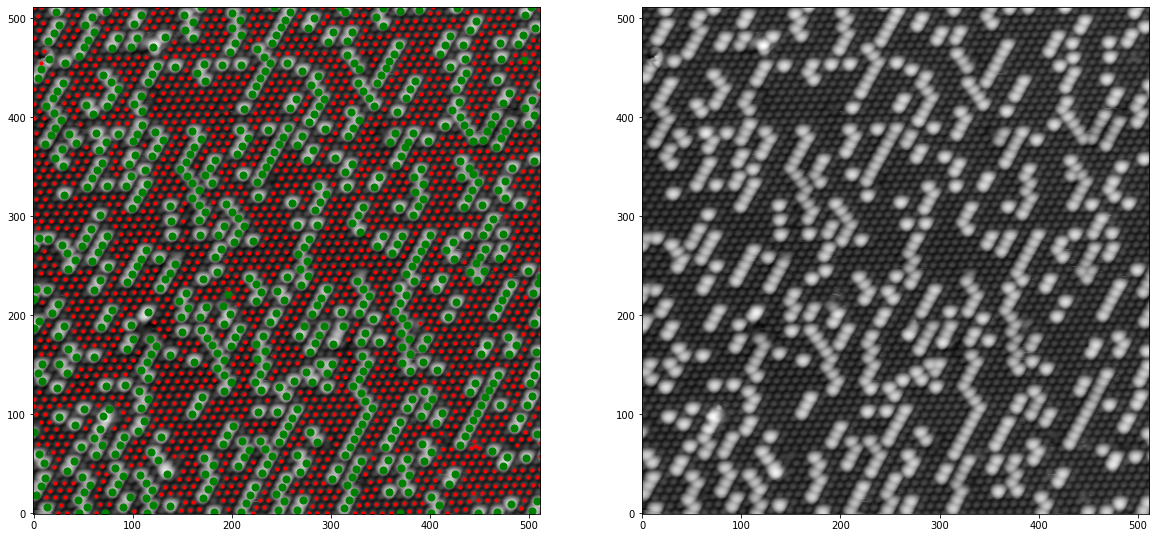

In [9]:
"""Change the values of threshold, min_sigma and max_sigma and
see how it effects the atom finding"""
B = blob_log(topo_s,threshold = 0.01,min_sigma = 2.0, max_sigma = 3.0)

mask_ad = (B[:,2])>2.4
mask_small = (B[:,2])<2.4
B_ad = B[mask_ad]
B_small = B[mask_small]
print(np.shape(B_small))
print(np.shape(B_ad))
fig,ax = plt.subplots(nrows = 1,ncols = 2,figsize = (20,20))
ax[0].imshow(topo_s, cmap = 'gray')
ax[0].scatter(B_ad[:,1],B_ad[:,0],c = 'g',s=50)
ax[0].scatter(B_small[:,1],B_small[:,0],c = 'r', s=10)
ax[0].invert_yaxis()

ax[1].imshow(topo_s, cmap = 'gray')
ax[1].invert_yaxis()
# ax.set_xticks([])
# ax.set_yticks([])
# plt.savefig('finding_atoms.png')

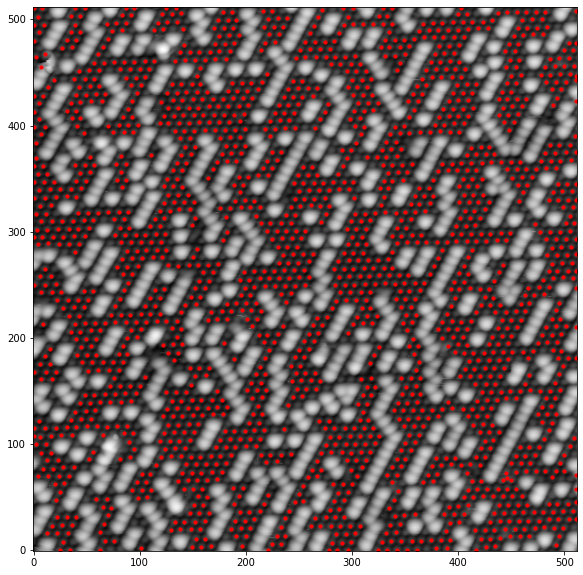

In [10]:
"""Deleting THE atom
There is one particular surface atom detected (which is actually noise) 
that caused a lot of problems while reconstruction, hence had to be deleted manually"""
mask = (B_small[:,1]>150)*(B_small[:,1]<170)*(B_small[:,0]>290)*(B_small[:,0]<300)
B_small = (B_small[~mask])
fig,ax = plt.subplots(figsize = (10,10))
ax.imshow(topo_s, cmap = 'gray')
ax.scatter(B_small[:,1],B_small[:,0],c = 'r', s=10)
ax.invert_yaxis()

# np.shape(B_small)

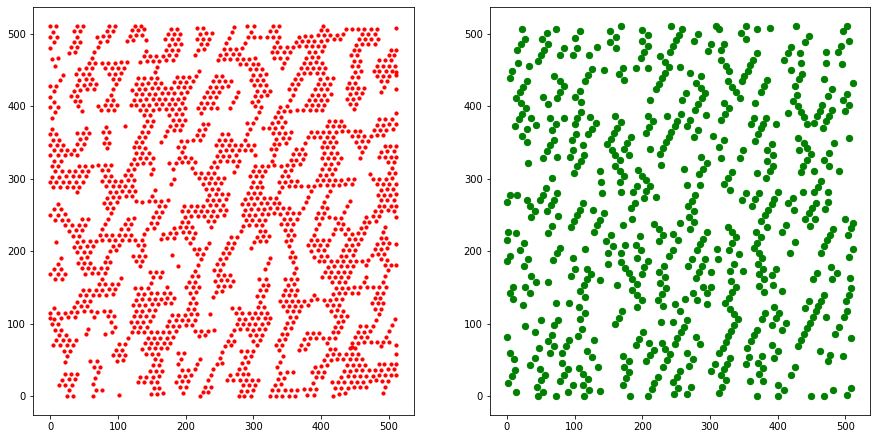

In [11]:
fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,7.5))
ax[0].scatter(B_small[:,1],B_small[:,0],c = 'r', s=10)
ax[1].scatter(B_ad[:,1],B_ad[:,0],c = 'g', s=40)

Output:

B_small, B_ad

y,x coordinates of **"ALL"** small and adsorbed atoms and,
sigma used to find each atom. (1.414*sigma is the radius of the atom)

# Cleaning up the surface (small) atoms

(1671, 6, 4)
0
(1665, 6, 4)


Text(0.5, 1.0, 'After disregarding closer atoms')

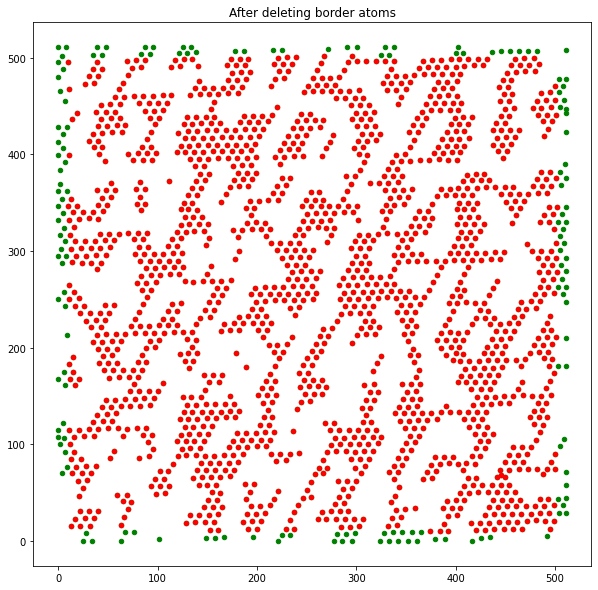

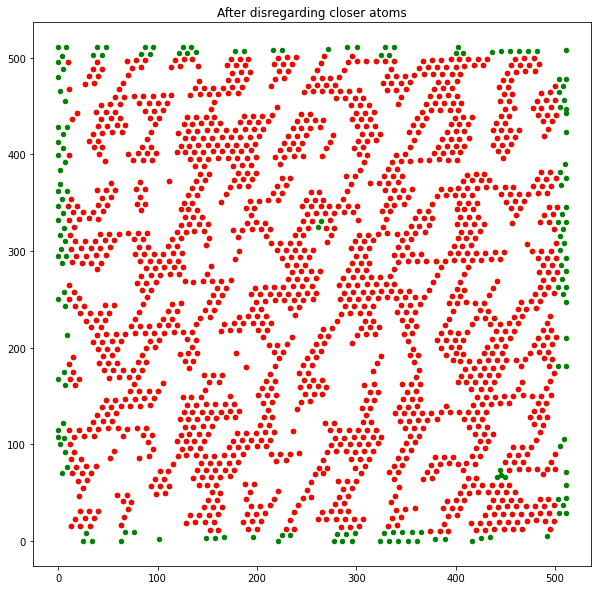

In [12]:
"""Remove the border atoms"""
B_small_bor = remove_border_atoms(B_small, thresh=10)

fig,ax = plt.subplots(figsize = (10,10))
ax.scatter(B_small[:,1],B_small[:,0],c = 'g', s=20)
ax.scatter(B_small_bor[:,1],B_small_bor[:,0],c = 'r', s=20)
ax.set_title('After deleting border atoms')

"""Remove the atoms that are closer to each other than a certain threshold"""
neigh_matrix_0 = estimate_nn(B_small_bor[:,0:2],B_small[:,0:2])
print(np.shape(neigh_matrix_0))

mask_clean_0 = (neigh_matrix_0[:,0,2]>7.20)

B_small_bor_1 = B_small_bor[mask_clean_0]

neigh_matrix_1 = estimate_nn(B_small_bor_1[:,0:2],B_small[:,0:2])

print(np.sum(neigh_matrix_1[:,0,2]<7.20))
print(np.shape(neigh_matrix_1))


fig,ax = plt.subplots(figsize = (10,10))
ax.scatter(B_small[:,1],B_small[:,0],c = 'g', s=20)
ax.scatter(B_small_bor_1[:,1],B_small_bor_1[:,0],c = 'r', s=20)
ax.set_title('After disregarding closer atoms')

**B_small_bor_1** are the set of surface atoms that are 'border cleaned' and 'nearest atoms cleaned' which are shown in red in the above fig. We will use only these atoms for reconstruction.  
**neigh_matrix_1** is the corresponding matrix after nn analysis

# Reconstruction of the surface atoms

8.187636754823458
8.867735704635834
9.730086288306296
11.222605010718945
13.435965819625185
15.111965968856722
(6932, 2)
[8.8146998  8.53714172 9.1819588  9.17394454 8.5454592  8.81355548]
8.844459920955957


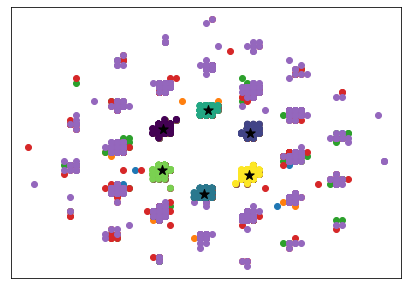

In [13]:
"""Nearest neighbors plot"""
near_neigh = np.zeros([len(B_small_bor_1),6,2])
for i,c in enumerate(B_small_bor_1):
    near_neigh[i] = neigh_matrix_1[i,:,0:2] - B_small_bor_1[i,0:2]
fig,ax = plt.subplots(figsize = (7,5))
ax.scatter(near_neigh[:,0,0],near_neigh[:,0,1], c = 'g')
ax.scatter(near_neigh[:,1,0],near_neigh[:,1,1])
ax.scatter(near_neigh[:,2,0],near_neigh[:,2,1])
ax.scatter(near_neigh[:,3,0],near_neigh[:,3,1])
ax.scatter(near_neigh[:,4,0],near_neigh[:,4,1])
ax.scatter(near_neigh[:,5,0],near_neigh[:,5,1])

for i in range(6):
    print(np.mean(neigh_matrix_1[:,i,2]))

"""selecting only the first nearest neighbors"""
winsize = 0 # size of a window around each spot to crop
orgpoint = [0, 0] # image center
r_cut = [11, 0] # outer / inner radius cut-off

r_cut_out, r_cut_in = r_cut
wsz = winsize

coordinates = np.empty((0, 2))

for i,c in enumerate(near_neigh):
    for j in range(6):
        dist = np.linalg.norm(c[j]-orgpoint)
        if dist < r_cut_out and dist > r_cut_in:
            coordinates = np.append(coordinates, [c[j]], axis=0)
        
left_over = np.array(coordinates)

ax.scatter(left_over[:,0],left_over[:,1])

print(np.shape(left_over))


"""Kmeans"""
kmeans = KMeans(n_clusters=6, random_state=0)
clus_pred = kmeans.fit_predict(left_over)
clus_cen = kmeans.cluster_centers_

ax.scatter(left_over[:, 0], left_over[:, 1], c=clus_pred)
ax.scatter(clus_cen[:,0],clus_cen[:,1], marker = '*',c = 'k', s = 100)
ax.set_xticks([])
ax.set_yticks([])
np.save('clus_cen.npy', clus_cen)

"""Average bond lengths"""
dist_near_neigh = np.zeros(6)
for i in range(6):
    dist_near_neigh[i] = ((np.linalg.norm(clus_cen[i]-orgpoint)))

print(dist_near_neigh)
avg_dist = np.mean(dist_near_neigh)
print(avg_dist)
plt.savefig('NN_plot.png')

In [14]:
"""Add-delete---Add-delete---Add-delete---Add-delete---Add-delete"""
B_small_bor_1[:,2] = 1.0

added_points_1 = add_points(B_small_bor_1,clus_cen)
print(len(added_points_1))
new_points_1 = cleaning_up(added_points_1,avg_dist, thresh=0.64)
print(len(new_points_1))

added_points_2 = add_points(new_points_1, clus_cen)
print(len(added_points_2))
new_points_2 = cleaning_up(added_points_2,avg_dist, thresh=0.64)
print(len(new_points_2))

added_points_3 = add_points(new_points_2, clus_cen)
print(len(added_points_3))
new_points_3 = cleaning_up(added_points_3,avg_dist, thresh=0.64)
print(len(new_points_3))

added_points_4 = add_points(new_points_3, clus_cen)
print(len(added_points_4))
new_points_4 = cleaning_up(added_points_4,avg_dist, thresh=0.64)
print(len(new_points_4))

added_points_5 = add_points(new_points_4, clus_cen)
print(len(added_points_5))
new_points_5 = cleaning_up(added_points_5,avg_dist, thresh=0.64)
print(len(new_points_5))

11655
3271
22651
3689
25354
3716
25520
3723
25554
3725


511.9862241576371 0.19836293846160835
511.9613289030962 0.017027261724345433
511.0 0.0
511.0 0.0


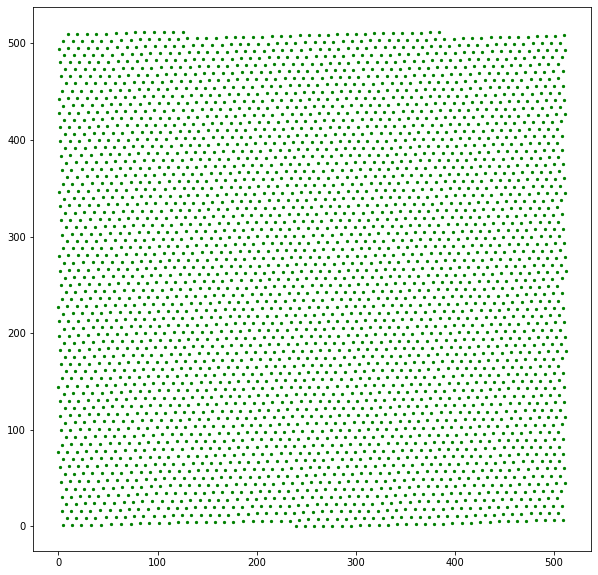

In [15]:
fig,ax = plt.subplots(figsize = (10,10))
ax.scatter(new_points_5[:,1],new_points_5[:,0],s = 5, c = 'g')
# ax.scatter(new_points_5[:,1],new_points_5[:,0],s = 5, c = 'r')
# ax.scatter(B_ad[:,1],B_ad[:,0],s = 10, c = 'g')
# ax.imshow(topo_s)
# ax.invert_yaxis()
# ax.set_xticks([])
# ax.set_yticks([])
# plt.savefig('surface_atoms.png')
print(np.amax(new_points_5[:,0]), np.amin(new_points_5[:,0]))
print(np.amax(new_points_5[:,1]), np.amin(new_points_5[:,1]))
print(np.amax(B_small[:,0]), np.amin(B_small[:,0]))
print(np.amax(B_small[:,1]), np.amin(B_small[:,1]))


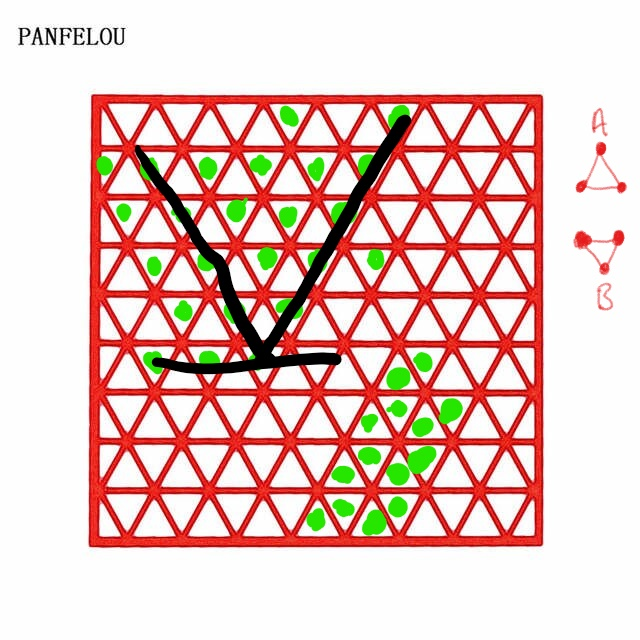

In [ ]:
Image('/content/InkedHote-Sale-Triangular-lattice-scrapbook-stencils-spray-plastic-mold-shield-DIY-cake-hollow-Embellishment-printing-lace.jpg_640x640q70_LI.jpg')

# Matrix Representation of surface atoms

In [16]:
# index_add = [[-1,1],
#             [1,-1],
#             [-1,-1],
#             [1,1],
#              [0,-2],
#              [0,2]]

# After deleting THE atom
index_add = [[-1,1],
            [1,1],
            [0,-2],
            [0,2],
             [-1,-1],
             [1,-1]]
             

#atom_index
#first two columns are y and x coordinates, next two are the indices in the same order
#Fifth column is whether the point is labelled and 6th is whether we have labelled its nearest neighbors
atom_index = np.zeros([len(new_points_5), 6])      


atom_index[:,0:2] = new_points_5[:,0:2]
atom_index[0,4] = 1

while(np.sum(atom_index[:,4]) < 3722):
  print(np.sum(atom_index[:,4]))
  for i,c in enumerate(atom_index):
    if c[4] == 1 and c[5] == 0:
      for k,d in enumerate(clus_cen):
        dummy_point = c[0:2]+d
        dist = np.abs((new_points_5[:,1]-dummy_point[1])+(1j*(new_points_5[:,0]-dummy_point[0])))
        if np.amin(dist)<0.25*8.84 and atom_index[np.argmin(dist),4] != 1:
          atom_index[np.argmin(dist),4] = 1    #Telling the code that the point is labelled
          atom_index[np.argmin(dist),2:4] = atom_index[i,2:4]+index_add[k]      #actual labels of the point
        
      atom_index[i,5] = 1            #Telling the code that the nearest neighbors are labelled
    


1.0
793.0
1911.0
2655.0
3173.0
3502.0
3621.0
3667.0
3694.0
3720.0


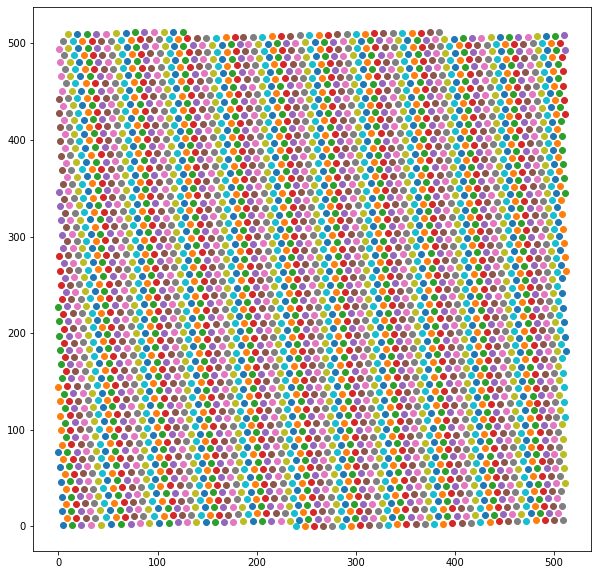

In [17]:
fig,ax = plt.subplots(figsize = (10,10))
# ax.scatter(atom_index[:,1],atom_index[:,0],s = 5, c = 'r')
# # ax.imshow(topo_s)
# # ax.invert_yaxis()
for i,ind in enumerate(np.unique(atom_index[:,3])):
  points_cons = atom_index[atom_index[:,3] == ind]
  ax.scatter(points_cons[:,1], points_cons[:,0])

# Possible sites

In [18]:
"""Since we are done with indexing the surface atoms,
let's find the possible sites (the triangles) for ad atoms to sit"""

indexed_sur_atoms = atom_index[atom_index[:,4].astype(bool)][:,0:4]
print(len(indexed_sur_atoms))

possible_sites = np.empty([0,2])
for k,c in enumerate(indexed_sur_atoms):
  y_ind = c[2]
  x_ind = c[3]

  y_points = indexed_sur_atoms[indexed_sur_atoms[:,2] == y_ind+1]
  x_point_1 = y_points[y_points[:,3] == x_ind-1]
  if len(x_point_1) != 0:
    point_1 = x_point_1[0,0:2]

  else:
    point_1 = []

  x_point_2 = y_points[y_points[:,3] == x_ind+1]
  if len(x_point_2) != 0:
    point_2 = x_point_2[0,0:2]

  else:
    point_2 = []

  if len(point_1) != 0 and len(point_2) != 0:
    possible_sites = np.append(possible_sites, ((point_1+point_2+c[0:2])/3).reshape([1,-1]), axis = 0)

3725


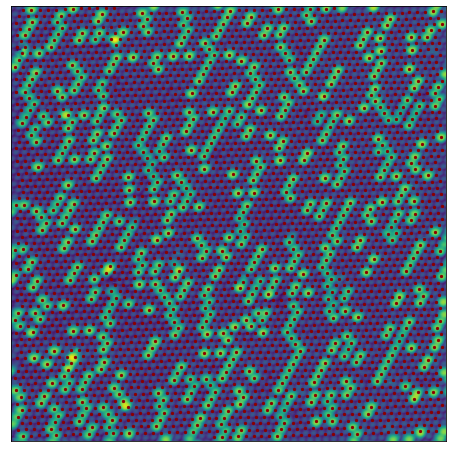

In [19]:
fig,ax = plt.subplots(figsize = (8,8))
# ax.scatter(new_points_3[:,1], new_points_3[:,0], s=2, c = 'b')
ax.scatter(possible_sites[:,1], possible_sites[:,0], s=5, c= 'darkred')
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(topo_s)
ax.invert_yaxis()
# plt.savefig('possible_sites_reconstructed.png')

# from google.colab import files
# files.download('possible_sites.png')

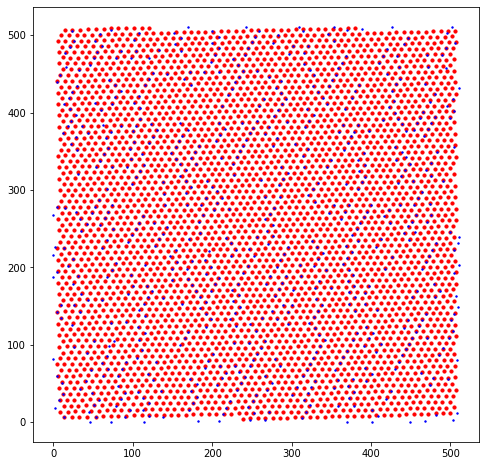

In [20]:
fig,ax = plt.subplots(figsize = (8,8))
ax.scatter(possible_sites[:,1], possible_sites[:,0], s=10, c= 'r')
ax.scatter(B_ad[:,1], B_ad[:,0], s=2, c = 'b')


# ax.imshow(topo_s)
# ax.invert_yaxis()

(3602, 2)


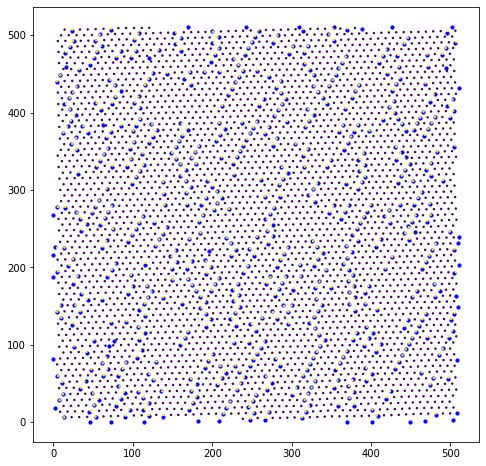

In [21]:
"""Checking whether there is an ad atom at possible sites"""
"""stats: first two are y and x coordinates
then whether the site is occupied and then y and x index of matrix representation"""
stats = np.zeros([len(possible_sites), 5])
stats[:,0:2] = possible_sites
stats[:,2] = -1
for i,pos in enumerate(stats):
    distance = np.abs((pos[1]-B_ad[:,1])+(1j*(pos[0]-B_ad[:,0])))
    if np.amin(distance)<3.5:
        stats[i,2] = +1

fig,ax = plt.subplots(figsize = (8,8))
ax.scatter(B_ad[:,1], B_ad[:,0], s=10, c = 'b')
ax.scatter(possible_sites[:,1], possible_sites[:,0], s=2, c = stats[:,2])


print(np.shape(possible_sites))
# ax.imshow(topo_s)
# ax.invert_yaxis()

# Matrix representation of possible sites

8.65701839802613
8.750947438547605
8.977720475820117
9.166782031360732
9.660758180852683
9.911479046617282


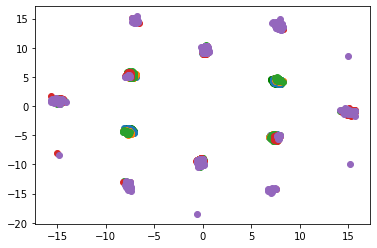

In [22]:
neigh_mat_sites = estimate_nn(stats[:,0:2],stats[:,0:2])
near_nei = np.zeros([len(stats),6,2])
for i,c in enumerate(stats):
    near_nei[i] = neigh_mat_sites[i,:,0:2] - stats[i,0:2]

plt.scatter(near_nei[:,0,0],near_nei[:,0,1], c = 'g')
plt.scatter(near_nei[:,1,0],near_nei[:,1,1])
plt.scatter(near_nei[:,2,0],near_nei[:,2,1])
plt.scatter(near_nei[:,3,0],near_nei[:,3,1])
plt.scatter(near_nei[:,4,0],near_nei[:,4,1])
plt.scatter(near_nei[:,5,0],near_nei[:,5,1])

for i in range(6):
    print(np.mean(neigh_mat_sites[:,i,2]))

(21130, 2)


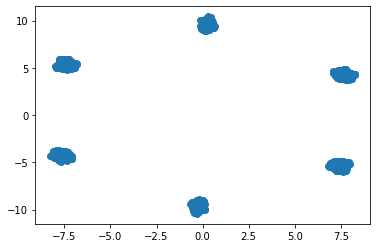

In [23]:
"""selecting only the first nearest neighbors"""
winsize = 0 # size of a window around each spot to crop
orgpoint = [0, 0] # image center
r_cut = [11, 0] # outer / inner radius cut-off

r_cut_out, r_cut_in = r_cut
wsz = winsize

coordinates = np.empty((0, 2))

for i,c in enumerate(near_nei):
    for j in range(6):
        dist = np.linalg.norm(c[j]-orgpoint)
        if dist < r_cut_out and dist > r_cut_in:
            coordinates = np.append(coordinates, [c[j]], axis=0)
        
left_over_sites = np.array(coordinates)

plt.scatter(left_over_sites[:,0],left_over_sites[:,1])

print(np.shape(left_over_sites))

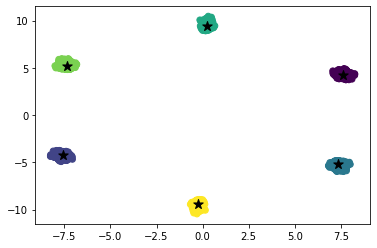

In [24]:
"""Kmeans"""
kmeans = KMeans(n_clusters=6, random_state=0)
clus_pred = kmeans.fit_predict(left_over_sites)
clus_cen_sites = kmeans.cluster_centers_
plt.scatter(left_over_sites[:, 0], left_over_sites[:, 1], c=clus_pred)
plt.scatter(clus_cen_sites[:,0],clus_cen_sites[:,1], marker = '*',c = 'k', s = 100)
# np.save('clus_cen.npy', clus_cen_sites)

In [25]:
index_add = [[1,1],
            [-1,-1],
            [1,-1],
            [0,2],
             [-1,1],
             [0,-2]]

             

#atom_index
#first two columns are y and x coordinates, next two are the indices in the same order
#Fifth column is whether the point is labelled and 6th is whether we have labelled its nearest neighbors
atom_index_sites = np.zeros([len(stats), 6])      


atom_index_sites[:,0:2] = stats[:,0:2]
atom_index_sites[0,4] = 1

while(np.sum(atom_index_sites[:,4]) < 3600):
  print(np.sum(atom_index_sites[:,4]))
  for i,c in enumerate(atom_index_sites):
    if c[4] == 1 and c[5] == 0:
      for k,d in enumerate(clus_cen_sites):
        dummy_point = c[0:2]+d
        dist = np.abs((stats[:,1]-dummy_point[1])+(1j*(stats[:,0]-dummy_point[0])))
        if np.amin(dist)<0.25*8.84 and atom_index_sites[np.argmin(dist),4] != 1:
          atom_index_sites[np.argmin(dist),4] = 1    #Telling the code that the point is labelled
          atom_index_sites[np.argmin(dist),2:4] = atom_index_sites[i,2:4]+index_add[k]      #actual labels of the point
        
      atom_index_sites[i,5] = 1            #Telling the code that the nearest neighbors are labelled
    


1.0
785.0
1886.0
2618.0
3115.0
3399.0
3496.0
3560.0
3581.0
3599.0


In [26]:
"""Stats is a matrix with y and x coordinates of the possible sites as the first two columns
followed by a column denoting whether the site is occupied or not then the last two columns 
correspond to y and x index correspondingly"""
stats[:,3:5] = atom_index_sites[:,2:4]    #Writing indices to stats array

stats[:,3] = stats[:,3]-np.amin(stats[:,3])   #Setting the minimum of the indices to zero 
stats[:,4] = stats[:,4]-np.amin(stats[:,4])
print(np.unique(stats[:,3]))
print(np.unique(stats[:,4]))


[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68.]
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112.]


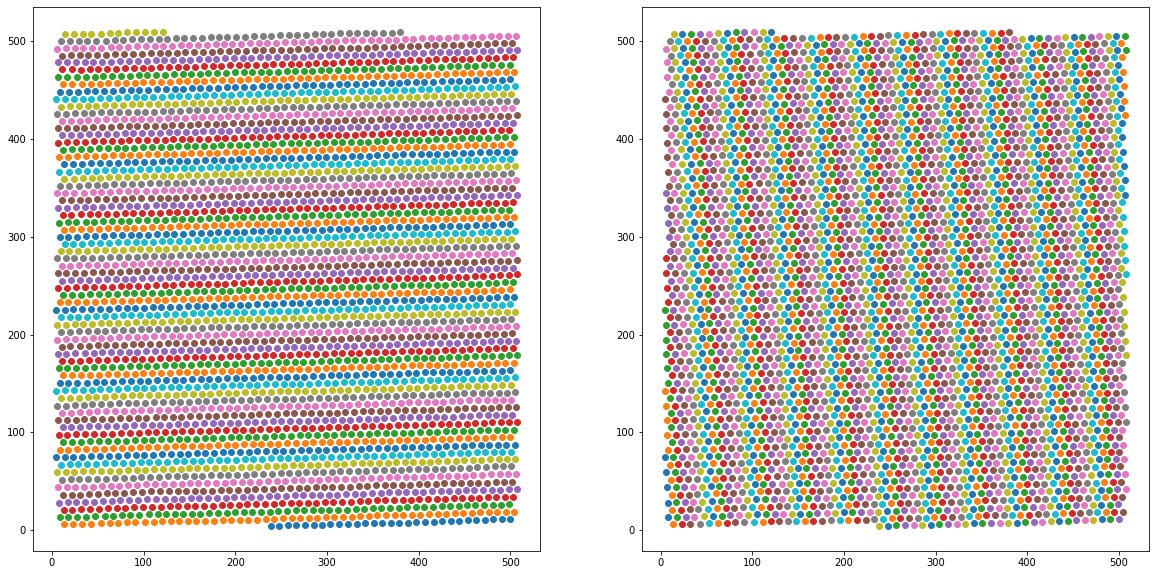

In [27]:
fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20,10))
# ax.scatter(atom_index[:,1],atom_index[:,0],s = 5, c = 'r')
# # ax.imshow(topo_s)
# # ax.invert_yaxis()
for i,ind in enumerate(np.unique(stats[:,3])):
  points_cons = stats[stats[:,3] == ind]
  ax[0].scatter(points_cons[:,1], points_cons[:,0])

for i,ind in enumerate(np.unique(stats[:,4])):
  points_cons = stats[stats[:,4] == ind]
  ax[1].scatter(points_cons[:,1], points_cons[:,0])

In [28]:
mask_rows_top = stats[:,3]<66   # Deleting top two rows
mask_rows_bottom = stats[:,3]>0   # Deleting bottom row
mask_columns_left = stats[:,4]>6
mask_columns_right = stats[:,4]<106

mask_total = mask_rows_top*mask_rows_bottom*mask_columns_left*mask_columns_right

stats_refined = stats[mask_total]

stats_refined[:,3] = stats_refined[:,3]-np.amin(stats_refined[:,3])   #Setting the minimum of the indices to zero 
stats_refined[:,4] = stats_refined[:,4]-np.amin(stats_refined[:,4])
print(np.unique(stats_refined[:,3]))
print(np.unique(stats_refined[:,4]))

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64.]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71.
 72. 73. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83. 84. 85. 86. 87. 88. 89.
 90. 91. 92. 93. 94. 95. 96. 97. 98.]


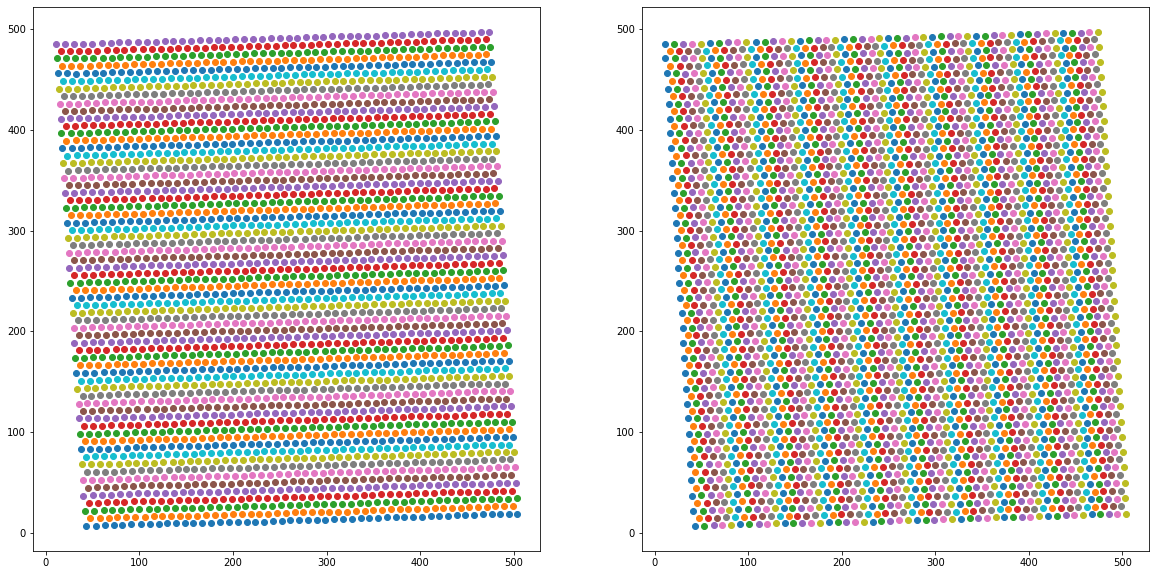

In [29]:
fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20,10))
# ax.scatter(atom_index[:,1],atom_index[:,0],s = 5, c = 'r')
# # ax.imshow(topo_s)
# # ax.invert_yaxis()
for i,ind in enumerate(np.unique(stats_refined[:,3])):
  points_cons = stats_refined[stats_refined[:,3] == ind]
  ax[0].scatter(points_cons[:,1], points_cons[:,0])

for i,ind in enumerate(np.unique(stats_refined[:,4])):
  points_cons = stats_refined[stats_refined[:,4] == ind]
  ax[1].scatter(points_cons[:,1], points_cons[:,0])

# Getting the statistics

In [30]:
configs_list = []
for a in range(-1,2,2):
  for b in range(-1,2,2):
    for c in range(-1,2,2):
      for d in range(-1,2,2):
        for e in range(-1,2,2):
          for f in range(-1,2,2):
            for g in range(-1,2,2):
              configs_list.append([a,b,c,d,e,f,g])


In [31]:
config = np.zeros([len(np.unique(stats_refined[:,3])),len(np.unique(stats_refined[:,4]))])
for i, c in enumerate(stats_refined):
  config[int(c[3]),int(c[4])] = c[2]

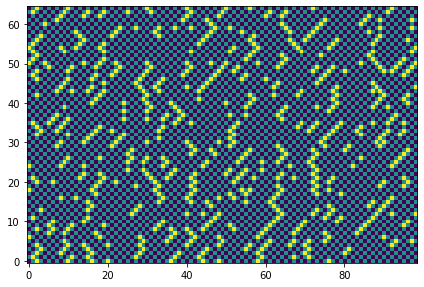

In [32]:
fig,ax = plt.subplots(figsize = (7,7))
ax.imshow(config)
ax.invert_yaxis()

In [33]:
M = np.amax(stats_refined[:,3])
N = np.amax(stats_refined[:,4])
print(M,N)
config_hist = np.zeros(shape=(len(configs_list)))
for i,k in enumerate(stats_refined):
  cen = k[2]
  a = config[int((k[3]-1)%M),int((k[4]-1)%N)]
  b = config[int((k[3]-1)%M),int((k[4]+1)%N)]
  c = config[int(k[3]),int((k[4]+2)%N)]
  d = config[int((k[3]+1)%M),int((k[4]+1)%N)]
  e = config[int((k[3]+1)%M),int((k[4]-1)%N)]
  f = config[int(k[3]),int((k[4]-2)%N)]

  config_vec = [cen, a, b, c, d, e, f]
  config_number = configs_list.index(config_vec)
  config_hist[int(config_number)]=config_hist[int(config_number)]+1
config_hist_norm = config_hist / (len(stats_refined))

64.0 98.0


<BarContainer object of 128 artists>

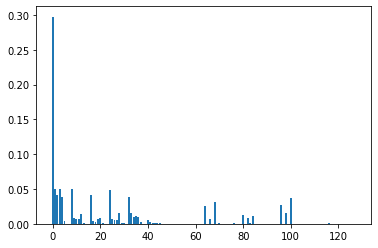

In [34]:
plt.bar(np.arange(len(config_hist_norm)), config_hist_norm)

In [35]:
print(np.unique(stats_refined[:,3]))
print(np.unique(stats_refined[:,4]))

print(np.sum(stats_refined[:,2] == 1.0))
print(np.sum(stats_refined[:,2] == -1.0))

print(len(stats_refined))


[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64.]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71.
 72. 73. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83. 84. 85. 86. 87. 88. 89.
 90. 91. 92. 93. 94. 95. 96. 97. 98.]
583
2635
3218


In [ ]:
np.save('zheng_histogram.npy', config_hist_norm)

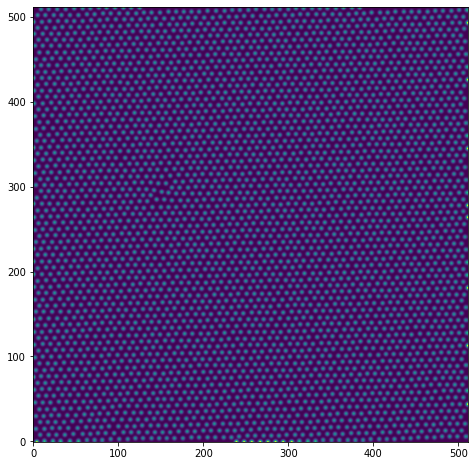

In [ ]:
"""Let's make the images from the points obtained from 2 methods
Method-2: Add-clean, Add-clean........ (Done 5 times)
output: new_points_5"""

def convolve_atomic_img(image_atoms, sigma):
  """Convolve input image with gaussian filter.
  Input: - image_atoms: 2D Numpy Array
         - sigma: int, optional, std. dev. of Gaussian
  Output: - filtered_image: 2D Numpy array, same size as input image"""
  
  return gaussian_filter(image_atoms,sigma,order = 0)

fig,ax = plt.subplots(figsize = (8,8))
img_ad_uncon = np.zeros([512,512])
for i in range(len(new_points_5)):
  x_img, y_img = new_points_5[i,0], new_points_5[i,1]
  img_ad_uncon[np.int(x_img),np.int(y_img)] = 1E6

img_ad = convolve_atomic_img(img_ad_uncon, sigma = 1.5)
ax.imshow(img_ad)
# ax.scatter(new_points_5[:,1],new_points_5[:,0],s = 2, c = 'r')
ax.invert_yaxis()


In [ ]:
"""Radon Transformations"""
from skimage.transform import radon
thetas = np.linspace(-180., 180., 720, endpoint=False)
sinogram = radon(img_ad, theta=thetas, circle = False)

radon_avg = np.zeros(len(thetas))
radon_std = np.zeros(len(thetas))
for i,theta in enumerate(thetas):
  radon_avg[i] = np.mean(sinogram[:,i])
  radon_std[i] = np.std(sinogram[:,i])


# print(np.shape(sinogram[23]))

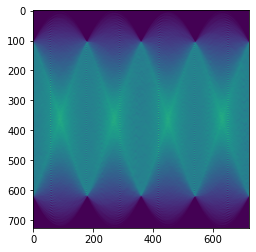

In [ ]:
plt.imshow(sinogram)

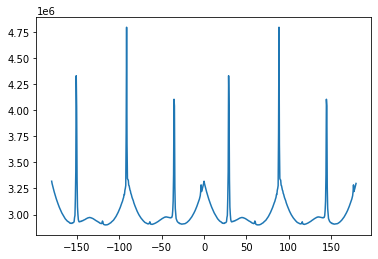

In [ ]:
plt.plot(thetas, radon_std)